## Importing Libraries
In this cell, we import essential libraries for data manipulation, visualization, and model building.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, GRU, RNN
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.optimizers import Adam
import math
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf

2025-06-09 21:24:26.604646: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading and Preprocessing Data
Here, we load the BTC_USDT dataset with 1min frequency and prepare it for training. 
Ensure that your dataset is time-indexed and contains ohlc and volume values.

In [4]:
# Step 1: Load the BTC/USDT 1min frequency dataset
def load_data(location):
    loc = location
    df = pd.read_csv(loc, sep=',', parse_dates={'time':['timestamp']}, 
                     infer_datetime_format=True, 
                     low_memory=False, na_values=['nan','?'])
    
    # Keep relevant columns and drop missing values
    df = df[['time', 'open', 'high', 'low', 'close', 'volume']].dropna()
    
    # Set the datetime as the index
    df.set_index('time', inplace=True)
    return df

# Load dataset
df = load_data('BTC_USDT_1m.csv')

/var/folders/75/krzxsmq97yn94ngdf1rt66th0000gq/T/ipykernel_11094/2764388472.py:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(loc, sep=',', parse_dates={'time':['timestamp']},
/var/folders/75/krzxsmq97yn94ngdf1rt66th0000gq/T/ipykernel_11094/2764388472.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(loc, sep=',', parse_dates={'time':['timestamp']},


In [5]:
# Step 2: Convert the data into a 5min format
# Convert columns to numeric
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Resample to 5min frequency and fill missing values
df = df.resample('5min', origin=df.index[0]).mean().fillna(method='ffill')   #.mean()

/var/folders/75/krzxsmq97yn94ngdf1rt66th0000gq/T/ipykernel_11094/1412039082.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.resample('5min', origin=df.index[0]).mean().fillna(method='ffill')   #.mean()


In [6]:
df.shape

(733900, 5)

## Plotting

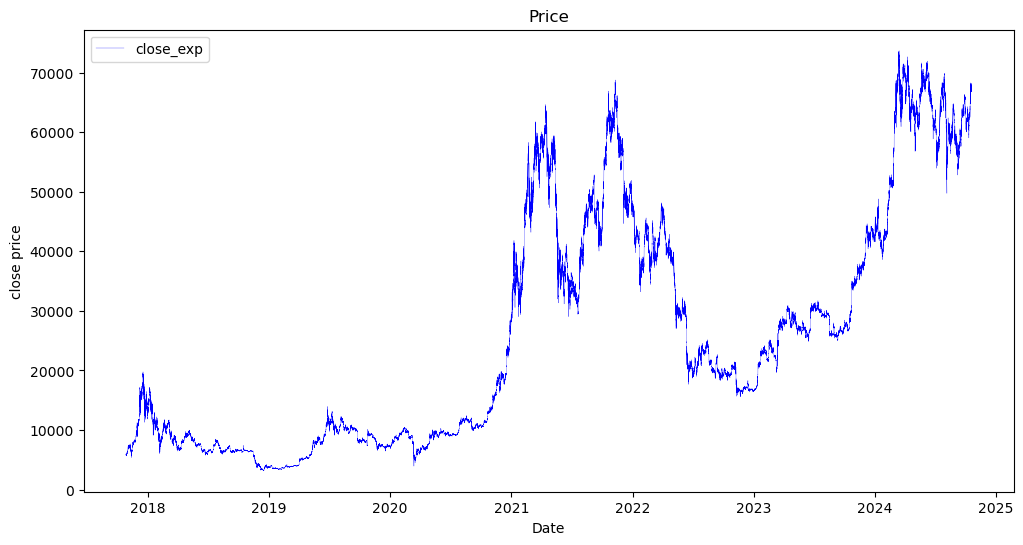

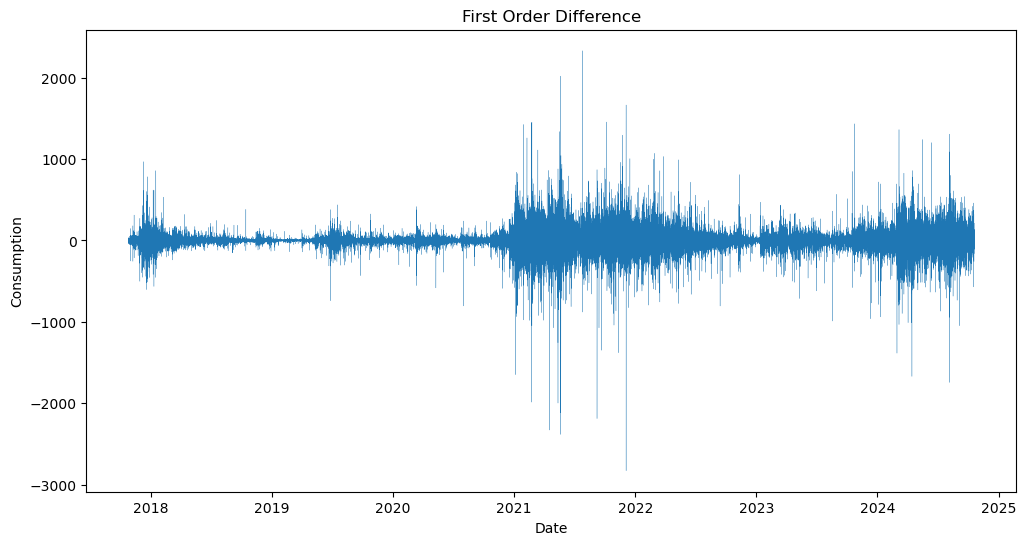

In [8]:
data = df.dropna()

# Visualize the dataset
plt.figure(figsize=(12, 6))
plt.plot(df['close'], linewidth=0.2, color='blue', label='close_exp')      #[15000:15000+1000]
plt.title('Price')
plt.xlabel('Date')
plt.ylabel('close price')
plt.legend()
plt.show()

# Visualize the dataset
plt.figure(figsize=(12, 6))
plt.plot(data['close'].diff(), linewidth=0.2, label='First Order Difference')
plt.title('First Order Difference')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.show()

## Preparing dataset for LSTM input

In [10]:
# Prepare data for LSTM
data_in = data[['open', 'high', 'low', 'close', 'volume']]

# Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0.01, 1))

In [11]:
# Function to define trading signal
def Trade_signal(data, take_profit, stop_loss):
    data = np.array(data)
    returns = ((data-data[0])/data[0])*100
    if max(returns) >= take_profit:
        ind_profit = np.where(returns>=1)[0][0]
        if min(returns[:ind_profit]) > -stop_loss:
            value = 1
        else:
            value = 0
    else:
        value = 0
    return value

# Prepare data with rolling time
def create_dataset_rolling(dataset, window=10, time_step=1):
    X, Y, X0, Y0, X1, Y1 = [], [], [], [], [], []
    for i in range(len(dataset) - time_step -window - 1):
        x = dataset[i:(i + time_step)]
        y = Trade_signal(dataset[(i + time_step-1):(i + time_step+window),0], take_profit, stop_loss)
        if y==1:
            X1.append(x)
            Y1.append(y)
        else:
            X0.append(x)
            Y0.append(y)
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y), np.array(X0), np.array(Y0), np.array(X1), np.array(Y1)

# Prepare data with time intervals of time_step/n
def create_dataset(dataset, window=10, time_step=1, n=5):
    X, Y, X0, Y0, X1, Y1 = [], [], [], [], [], []
    for i in range(0, len(dataset)-time_step-window-1, int(time_step/n)):
        x = dataset[i:(i + time_step)]
        y = Trade_signal(dataset[(i + time_step-1):(i + time_step+window),0], take_profit, stop_loss)
        if y==1:
            X1.append(x)
            Y1.append(y)
        else:
            X0.append(x)
            Y0.append(y)
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)#, np.array(X0), np.array(Y0), np.array(X1), np.array(Y1)

# Setting Parameters
take_profit = 1
stop_loss = 2
time_step = 128  # sequence length
window = 100     # 100*5 Next 500 min
n = 15   # Data derived per timestep/n intervals

# Split dataset into train test and validation set.
X, Y = create_dataset(scaler.fit_transform(data_in), window, time_step, n)
X_train, y_train = create_dataset(scaler.fit_transform(data_in.iloc[:513730]), window, time_step, n)
X_val, y_val = create_dataset(scaler.fit_transform(data_in.iloc[513730:513730+110085]), window, time_step, n)
X_test, y_test = create_dataset(scaler.fit_transform(data_in.iloc[513730+110085:513730+110085+73390]), window, time_step, n)

In [12]:
X_test.shape

(9146, 128, 5)

In [13]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 5)

In [14]:
# Opportunities ratio.
ratio_train = np.sum(y_train)/len(y_train)
print('training class 1 ratio->',ratio_train)

ratio_train = np.sum(y_val)/len(y_val)
print('Validation class 1 ratio->',ratio_train)

ratio_train = np.sum(y_test)/len(y_test)
print('test class 1 ratio->',ratio_train)

# ratio = np.sum(Y)/len(Y)
# print('Data class 1 ratio->',ratio)

training class 1 ratio-> 0.5076338256371907
Validation class 1 ratio-> 0.5171861345761725
test class 1 ratio-> 0.5813470369560464


In [15]:
from sklearn.utils import class_weight

# Compute class weights to address imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [16]:
class_weights_dict

{0: 1.0155043665358816, 1: 0.9849619445126443}

#### Marking opportunities on price plot

/var/folders/75/krzxsmq97yn94ngdf1rt66th0000gq/T/ipykernel_11094/1995834216.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(df.index[0:len(df)-time_step-window-1:int(time_step/n)][indexes], df['close'][0:len(df)-time_step-window-1:int(time_step/n)][indexes], color='red', s=0.01)  #df.index[0:len(df)-window-1:time_step],


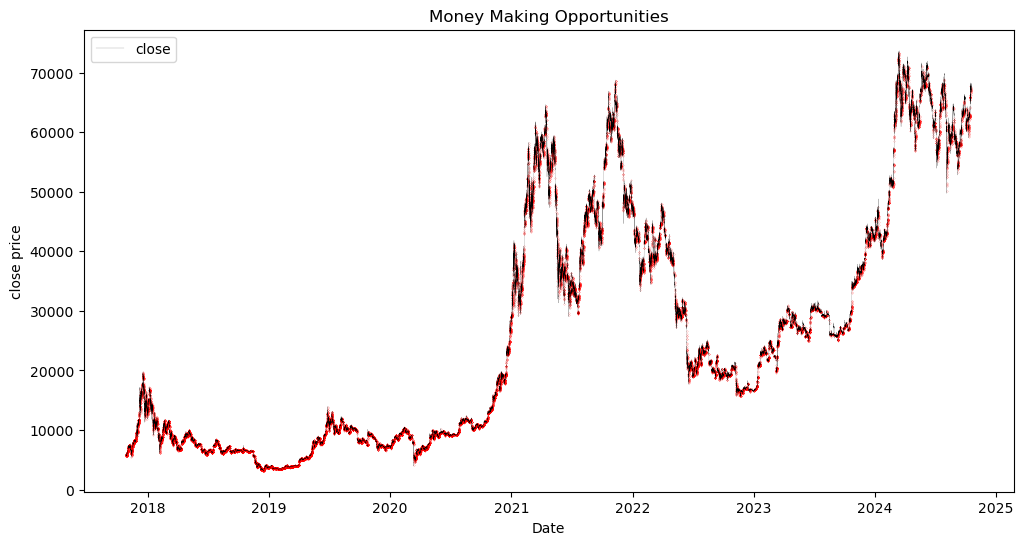

In [18]:
# Times when we can make trade
indexes = np.where(Y==1)[0]

# Visualize the dataset
plt.figure(figsize=(12, 6))
plt.plot(df['close'], linewidth=0.1, color='black', label='close')
# plt.scatter(df.index[0:len(df)-time_step-window-1:int(time_step/10)][indexes], df['close'][0:len(df)-time_step-window-1:int(time_step/10)], c=list(Y), s=2, cmap='Reds', alpha=1)  #df.index[0:len(df)-window-1:time_step], 
plt.scatter(df.index[0:len(df)-time_step-window-1:int(time_step/n)][indexes], df['close'][0:len(df)-time_step-window-1:int(time_step/n)][indexes], color='red', s=0.01)  #df.index[0:len(df)-window-1:time_step], 
plt.title('Money Making Opportunities')
plt.xlabel('Date')
plt.ylabel('close price')
plt.legend()
plt.show()

## LSTM Model
The LSTM is a type of recurrent neural network that is effective for sequential data. 
Here, we train an LSTM model on the historical energy consumption data and predict the next 720 mins (12 hours).

In [20]:
dropout_rate = 0.2
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.7)
# Build LSTM Model
lstm_model = Sequential([
    GRU(40, return_sequences=False, activation = 'relu', dropout = dropout_rate, input_shape=(X_train.shape[1], 5), kernel_initializer=initializer),
    BatchNormalization(),
    Dense(20, activation = 'relu', kernel_initializer=initializer),
    BatchNormalization(),
    Dense(10, activation='relu', kernel_initializer=initializer),
    BatchNormalization(),
    Dense(5, activation='relu', kernel_initializer=initializer),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

# LSTM(100, return_sequences=True, activation = 'relu', dropout = dropout_rate, recurrent_dropout = dropout_rate, input_shape=(X_train.shape[1], 5)),
    # BatchNormalization(),

lstm_model.compile(optimizer=Adam(learning_rate=0.0001, clipnorm=0.5), loss='binary_crossentropy', metrics=['accuracy'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 40)             │         5,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40)             │           160 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5)              │            20 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,031 (27.46 KB)

 Trainable params: 6,881 (26.88 KB)

 Non-trainable params: 150 (600.00 B)

In [22]:
# Comment line below if you want to reload presaved weights.
os.system('rm BTC_Trading_ckpt.keras')
# Creating model checkpoint
checkpoint_path = "BTC_Trading_ckpt.keras"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 verbose=1)

# Train the LSTM model with the new callback
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, class_weight=class_weights_dict, validation_data=(X_val, y_val), callbacks=[cp_callback])    #, class_weight=class_weights_dict

lstm_model.save('BTC_Trading.keras')

Epoch 1/20
2005/2006 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4851 - loss: 0.8423
Epoch 1: saving model to BTC_Trading_ckpt.keras
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 79s 37ms/step - accuracy: 0.4851 - loss: 0.8422 - val_accuracy: 0.5576 - val_loss: 0.7060
Epoch 2/20
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5085 - loss: 0.7169
Epoch 2: saving model to BTC_Trading_ckpt.keras
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 75s 37ms/step - accuracy: 0.5085 - loss: 0.7169 - val_accuracy: 0.5631 - val_loss: 0.6935
Epoch 3/20
2005/2006 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5148 - loss: 0.7022
Epoch 3: saving model to BTC_Trading_ckpt.keras
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 74s 37ms/step - accuracy: 0.5148 - loss: 0.7022 - val_accuracy: 0.5671 - val_loss: 0.6883
Epoch 4/20
2005/2006 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5151 - loss: 0.6978
Epoch 4: saving model to BTC_Trading_ckpt.keras
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 75s 37ms/step - accuracy: 0.5151 - loss: 0.6978 - val_accu

In [23]:
# Save the entire model as a `.keras` zip archive.
lstm_model = keras.models.load_model('BTC_Trading.keras')

# Evaluate the model on test and validation set.
val_loss = lstm_model.evaluate(X_val, y_val, verbose=0)
test_loss = lstm_model.evaluate(X_test, y_test, verbose=0)

print('Validation loss:',val_loss)
print('Test loss:',test_loss)

# make predictions
probabilities_val = lstm_model.predict(X_val)
probabilities_test = lstm_model.predict(X_test)
probabilities_train = lstm_model.predict(X_train)

Validation loss: [0.6830278635025024, 0.583964467048645]
Test loss: [0.6892737150192261, 0.5181500315666199]
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
2006/2006 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step


## Loss at different thresholds

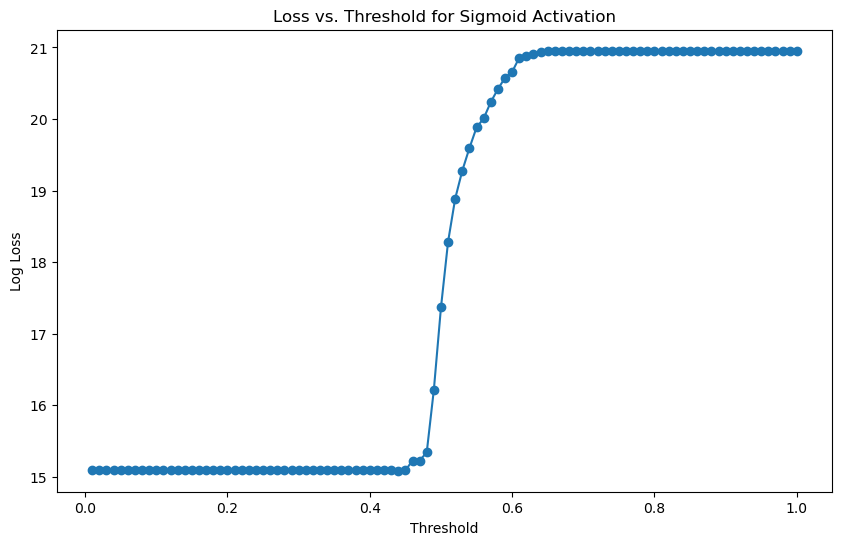

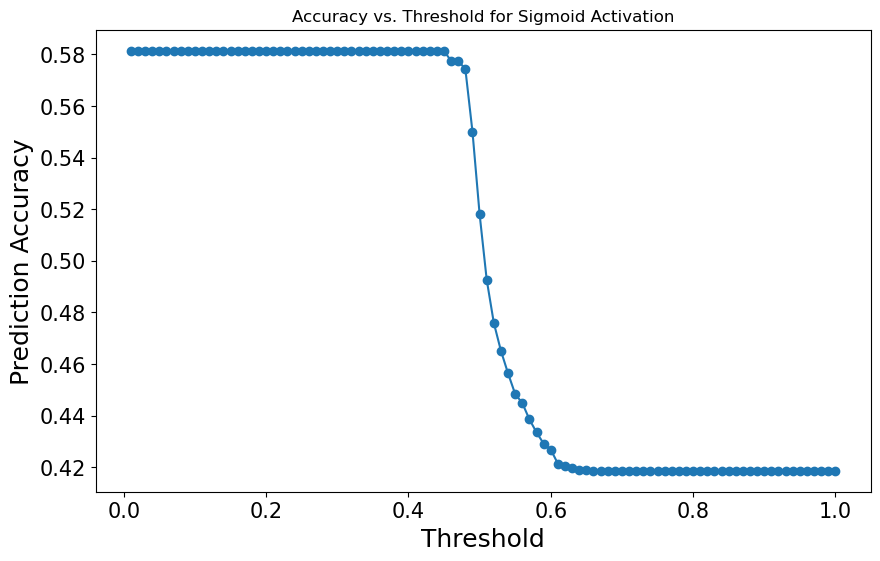

In [25]:
from sklearn.metrics import log_loss, accuracy_score

# Evaluate loss at different thresholds
def evaluate_loss_at_thresholds(probabilities, y_true, thresholds):
    losses = []
    accuracy = []
    for threshold in thresholds:
        y_pred = (np.array(probabilities) >= threshold).astype(int)
        loss = log_loss(y_true, y_pred)
        accu = accuracy_score(y_true, y_pred)
        losses.append(loss)
        accuracy.append(accu)
    return losses, accuracy

thresholds = np.arange(0.01, 1.01, 0.01)  # Thresholds from 0.0 to 1.0 in steps of 0.1
losses, accuracy = evaluate_loss_at_thresholds(probabilities_test, y_test, thresholds)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, losses, marker='o')
plt.title('Loss vs. Threshold for Sigmoid Activation')
plt.xlabel('Threshold')
plt.ylabel('Log Loss')
# plt.ylim(13.58,13.62)
# plt.grid(True)
plt.savefig('lossVSthreshold.png', transparent=True)
plt.show()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracy, marker='o')
plt.title('Accuracy vs. Threshold for Sigmoid Activation')
plt.xlabel('Threshold', fontsize=18)
plt.ylabel('Prediction Accuracy', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.ylim(13.58,13.62)
# plt.grid(True)
plt.savefig('accuracyVSthreshold.png', transparent=True)
plt.show()

In [26]:
opt_thresh = thresholds[np.where(np.array(losses)==min(losses))[0][0]]
opt_thresh

0.44

#### Plot to visualize prediction accuracy
- Clear seperation between yellow and purple points on the plot signifies good test accuracy
- Algorithm is assigning class randomly

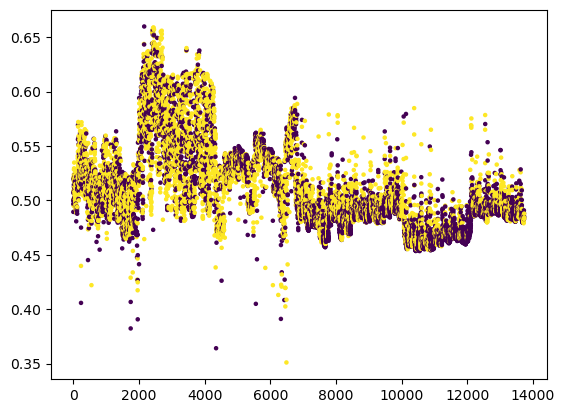

In [28]:
y_val_model = (np.array(probabilities_val) >= opt_thresh).astype(int)
plt.scatter(list(range(len(y_val))), probabilities_val, c=y_val, s=5)

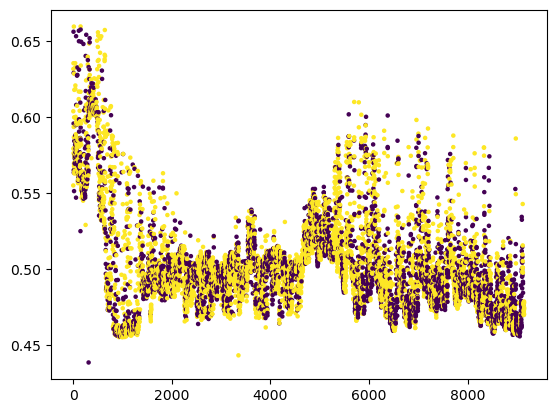

In [29]:
y_test_model = (np.array(probabilities_test) >= opt_thresh).astype(int)
plt.scatter(list(range(len(y_test))), probabilities_test, c=y_test, s=5)

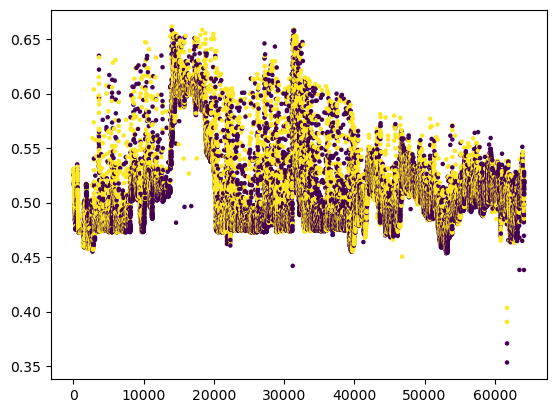

In [30]:
y_train_model = (np.array(probabilities_train) >= opt_thresh).astype(int)
plt.scatter(list(range(len(y_train))), probabilities_train, c=y_train, s=5)

## Plotting returns at different threshold

0.0
-1008943.2486899571
0.01
-1008943.2486899571
0.02
-1008943.2486899571
0.03
-1008943.2486899571
0.04
-1008943.2486899571
0.05
-1008943.2486899571
0.06
-1008943.2486899571
0.07
-1008943.2486899571
0.08
-1008943.2486899571
0.09
-1008943.2486899571
0.1
-1008943.2486899571
0.11
-1008943.2486899571
0.12
-1008943.2486899571
0.13
-1008943.2486899571
0.14
-1008943.2486899571
0.15
-1008943.2486899571
0.16
-1008943.2486899571
0.17
-1008943.2486899571
0.18
-1008943.2486899571
0.19
-1008943.2486899571
0.2
-1008943.2486899571
0.21
-1008943.2486899571
0.22
-1008943.2486899571
0.23
-1008943.2486899571
0.24
-1008943.2486899571
0.25
-1008943.2486899571
0.26
-1008943.2486899571
0.27
-1008943.2486899571
0.28
-1008943.2486899571
0.29
-1008943.2486899571
0.3
-1008943.2486899571
0.31
-1008943.2486899571
0.32
-1008943.2486899571
0.33
-1008943.2486899571
0.34
-1008943.2486899571
0.35000000000000003
-1008943.2486899571
0.36
-1008861.5280700246
0.37
-1008807.0454371062
0.38
-1008807.0454371062
0.39
-1008725.

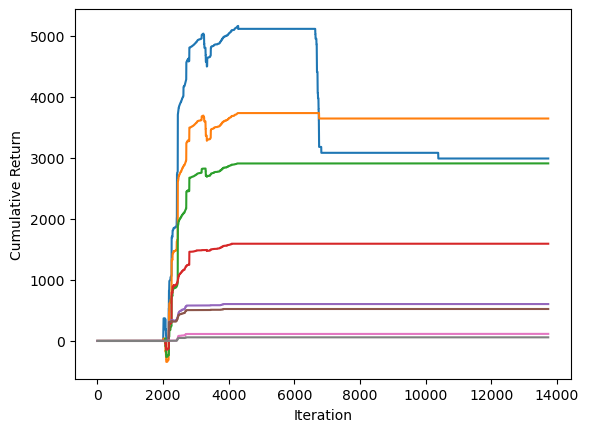

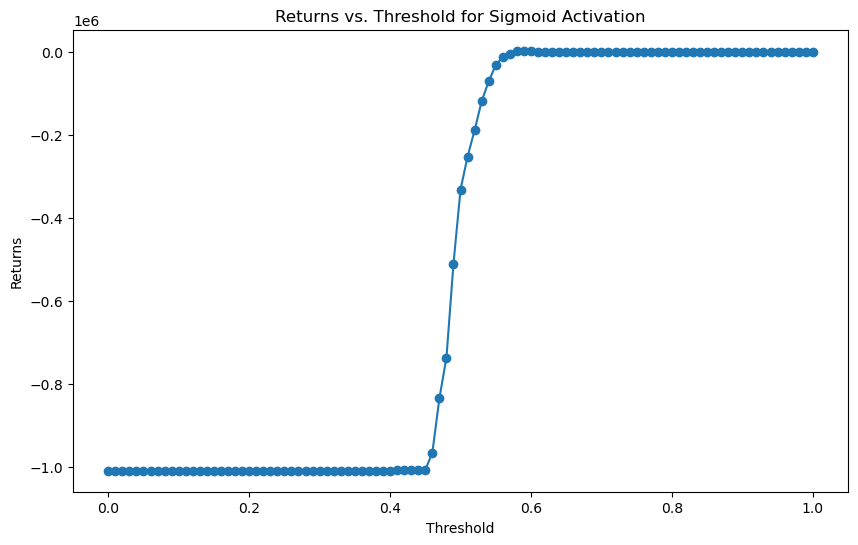

In [32]:
# Evaluate loss at different thresholds
def evaluate_return_at_thresholds(probabilities, X, thresholds):
    total_returns = []
    for threshold in thresholds:
        y_pred = (np.array(probabilities) >= threshold).astype(int)
        return_series = []
        returns = 0
        good_return = 0
        bad_return = 0
        for iter, inp in enumerate(X[:,0]):
            if y_pred[iter] == 0:
                value = 0
            else:
                try:
                    inp_returns = ((inp-inp[0])/inp[0])*100
                    ind_profit = np.where(inp_returns>=1)[0][0]
                    value = inp_returns[ind_profit]
                    good_return += value
                except IndexError:
                    value = inp_returns[-1]
                    bad_return += value
            returns = returns + value
            return_series.append(returns)
        print(threshold)
        print(good_return + bad_return)
        if good_return + bad_return > 0:
            # plotting thresholds with net positive retuns
            plt.plot(range(len(return_series)) , return_series, label=str(threshold))
        total_returns.append(return_series[-1])
    plt.xlabel('Iteration')
    plt.ylabel('Cumulative Return')
    # plt.legend()
    plt.savefig('Returns_no_lable_val.png', transparent=True)
    plt.show()
    return total_returns

thresholds = np.arange(0.0, 1.01, 0.01)  # Thresholds from 0.0 to 1.0 in steps of 0.1
returns = evaluate_return_at_thresholds(probabilities_val, X_val, thresholds)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, returns, marker='o')
plt.title('Returns vs. Threshold for Sigmoid Activation')
plt.xlabel('Threshold')
plt.ylabel('Returns')
# plt.ylim(13.58,13.62)
# plt.grid(True)
plt.show()

## Estimating different performance metrics for our strategy

#### Validation Set

In [35]:
from sklearn.metrics import log_loss, accuracy_score, precision_score, f1_score

opt_return_threshold = 0.6
y_pred_test = (np.array(probabilities_val) >= opt_return_threshold).astype(int)
return_series = []
returns = 0
good_return = 0
bad_return = 0
for iter, inp in enumerate(X_val[:,0]):
    if y_pred_test[iter] == 0:
        value = 0
    else:
        try:
            inp_returns = ((inp-inp[0])/inp[0])*100
            ind_profit = np.where(inp_returns>=1)[0][0]
            value = inp_returns[ind_profit]
            good_return += value
        except IndexError:
            value = inp_returns[-1]
            bad_return += value
    returns = returns + value
    return_series.append(value)
print(opt_return_threshold)
print(f"Total Returns -> {good_return + bad_return}")


loss = log_loss(y_val, y_val_model)
accu = accuracy_score(y_val, y_val_model)
precision = precision_score(y_val, y_val_model)
F1 = f1_score(y_val, y_val_model)
non0_returns = [i for i in return_series if i != 0]
sharpe_ratio = np.mean(non0_returns)/np.std(non0_returns)
profit_factor = good_return/(-1*bad_return)

print(f"loss: {loss} \naccuracy: {accu} \nprecision: {precision} \nF1-score: {F1} \nSharpe Ration: {sharpe_ratio} \nProfit Factor: {profit_factor}")

0.6
Total Returns -> 2909.8976532881843
loss: 17.42074916571297 
accuracy: 0.5166763763472182 
precision: 0.5169695642653821 
F1-score: 0.6809594769985098 
Sharpe Ration: 0.1248247921083139 
Profit Factor: 6.845568002057001


#### Test Set

In [37]:
from sklearn.metrics import log_loss, accuracy_score, precision_score, f1_score

opt_return_threshold = 0.6
y_pred_test = (np.array(probabilities_test) >= opt_return_threshold).astype(int)
return_series = []
returns = 0
good_return = 0
bad_return = 0
for iter, inp in enumerate(X_test[:,0]):
    if y_pred_test[iter] == 0:
        value = 0
    else:
        try:
            inp_returns = ((inp-inp[0])/inp[0])*100
            ind_profit = np.where(inp_returns>=1)[0][0]
            value = inp_returns[ind_profit]
            good_return += value
        except IndexError:
            value = inp_returns[-1]
            bad_return += value
    returns = returns + value
    return_series.append(value)
print(opt_return_threshold)
print(f"Total Returns -> {good_return + bad_return}")


loss = log_loss(y_test, y_test_model)
accu = accuracy_score(y_test, y_test_model)
precision = precision_score(y_test, y_test_model)
F1 = f1_score(y_test, y_test_model)
non0_returns = [i for i in return_series if i != 0]
sharpe_ratio = np.mean(non0_returns)/np.std(non0_returns)
profit_factor = good_return/(-1*bad_return)

print(f"loss: {loss} \naccuracy: {accu} \nprecision: {precision} \nF1-score: {F1} \nSharpe Ration: {sharpe_ratio} \nProfit Factor: {profit_factor}")

0.6
Total Returns -> 1330.378986054152
loss: 15.085841370384916 
accuracy: 0.5814563743713098 
precision: 0.5814106068890104 
F1-score: 0.7353063200110634 
Sharpe Ration: 0.07968699577949384 
Profit Factor: 1.602762446310099


## Debugging 

In [ ]:
non0_returns = [i for i in return_series if i != 0]

In [ ]:
non0_returns

In [ ]:
plt.plot(np.sort(return_series))

In [ ]:
max(return_series)

In [ ]:
min(return_series)

In [ ]:
np.sum(return_series)/len(return_series)

In [ ]:
np.sum((np.array(return_series)-np.mean(return_series))**2/ len(return_series))

In [ ]:
np.std(return_series)

In [ ]:
print(np.sum(np.isnan(probabilities_val)))
print

In [ ]:
np.sum(probabilities_test)

In [ ]:
y_pred_val = (probabilities_val >= 0.5).astype(int)

print(len(y_val))
np.sum(y_pred_val)

In [ ]:
np.sum(np.array(tf.argmax(input=probabilities_test, axis=1)))

In [ ]:
np.sum(np.isinf(X_train))